In [1]:
import harmony
import palantir

# Plotting and miscellaneous imports
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Initialize random seed
import random
random.seed(101)

%matplotlib inline

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


ModuleNotFoundError: No module named 'palantir'

In [2]:
harmony_dir = '/projects/pytrik/sc_adipose/analyze_10x_fluidigm/10x-adipocyte-analysis/output/harmony/data/'

csv_files = [harmony_dir + '180831_T1_raw-data_2890cells.csv',
            harmony_dir + '180831_T2_raw-data_5211cells.csv',
            harmony_dir + '180831_T3_raw-data_5474cells.csv',
            harmony_dir + '180831_T4_raw-data_3714cells.csv',
            harmony_dir + '180831_T5_raw-data_6139cells.csv']
sample_names = ['T1', 'T2', 'T3', 'T4', 'T5']

counts = harmony.utils.load_from_csvs(csv_files, sample_names)

Loading count matrices...
T1
T2
T3
T4
T5
Concatenating data..


In [3]:
norm_df = harmony.utils.normalize_counts(counts)

In [4]:
hvg_genes = harmony.utils.hvg_genes(norm_df)

In [5]:
len(hvg_genes)
hvg_genes

Index(['MT1G', 'REN', 'FABP4', 'MT2A', 'MT1X', 'MTRNR2L1', 'IGF2', 'CFD',
       'NPPB', 'MT1A',
       ...
       'CYP26A1', 'COLCA2', 'RP11-572C15.6', 'TRIB1', 'ARHGAP12', 'SETBP1',
       'PROCR', 'PID1', 'RP1-251M9.2', 'NGF'],
      dtype='object', length=1000)

In [6]:
monocle_genes = [gene.strip() for gene in open('/projects/pytrik/sc_adipose/analyze_10x_fluidigm/10x-adipocyte-analysis/output/markergenes/180831/monocle_genelist_T1T2T3_T4T5_res.1.5', 'r')]
print(len(monocle_genes))
monocle_genes[1:10]

2464


['NREP',
 'CTHRC1',
 'ANXA2',
 'AEBP1',
 'PDLIM7',
 'MOXD1',
 'GLIPR2',
 'CRABP2',
 'S100A11']

From the tutorial: "Data can be optionally log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale."
Therefore, keep both the normalized and log normalized data. 

In [7]:
data_df_log = harmony.utils.log_transform(norm_df.loc[:,monocle_genes])
#data_df_log = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])
data_df = norm_df

<h3>Metadata</h3>

In [8]:
metadata = pd.read_csv('/projects/pytrik/sc_adipose/analyze_10x_fluidigm/10x-adipocyte-analysis/output/harmony/data/180831_metadata_23428cells.csv', index_col=0)

NameError: name 'pd' is not defined

In [ ]:
index = list(map(lambda x: 'T' + x[-1] + '_' + x, metadata.index))
metadata.index = index

<h3>Harmony augmented affinity matrix</h3>

In [ ]:
timepoints = ['T1', 'T2', 'T3', 'T4', 'T5']
tp = pd.Series(index=data_df.index)
for t in timepoints:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [ ]:
timepoint_connections = pd.DataFrame(columns=[0, 1])
index = 0
for i in range(len(timepoints)-1):
    timepoint_connections.loc[index, :] = timepoints[i:i+2]; index += 1
timepoint_connections

In [ ]:
#aug_aff, aff = harmony.core.augmented_affinity_matrix(data_df, tp, timepoint_connections)
aug_aff_log, aff_log = harmony.core.augmented_affinity_matrix(data_df_log, tp, timepoint_connections)


<h3>Visualization using force directed layouts</h3>

In [ ]:
#layout = harmony.plot.force_directed_layout(aug_aff, data_df.index)
layout_log = harmony.plot.force_directed_layout(aug_aff_log, data_df.index)

<b>Layout non log-transformed data</b>

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


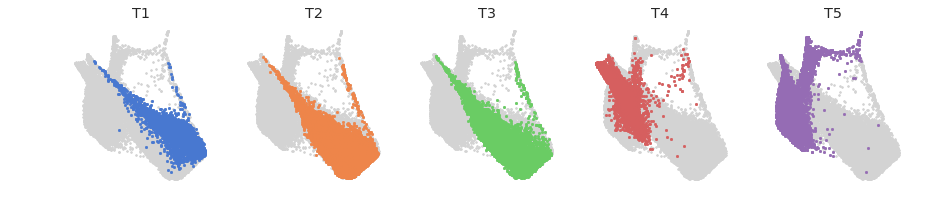

In [48]:
harmony.plot.plot_timepoints(layout, tp)

Monocle branches

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


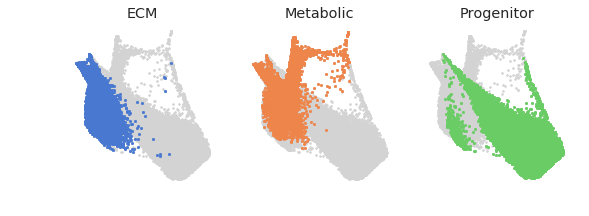

In [49]:
harmony.plot.plot_timepoints(layout, metadata['branch'])

<b>Palantir trajectory detection non log-transformed data</b>

The first step in Palantir trajectory detection is to project data onto diffusion maps. Harmony augmented affinity matrix is used as the input for identifying diffusion maps. 

In [76]:
dm_res = palantir.utils.run_diffusion_maps(aug_aff)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [77]:
#Start cell was chosen on Monocle pseudotime == 0.
start_cell = 'T1_TCTGGAAAGTGCGATG-1'
pr_res = palantir.core.run_palantir(ms_data, start_cell, use_early_cell_as_start=False)

Sampling and flocking waypoints...
Time for determining waypoints: 0.04483475685119629 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.812998112042745 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir results. The second row shows the identified branches.

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


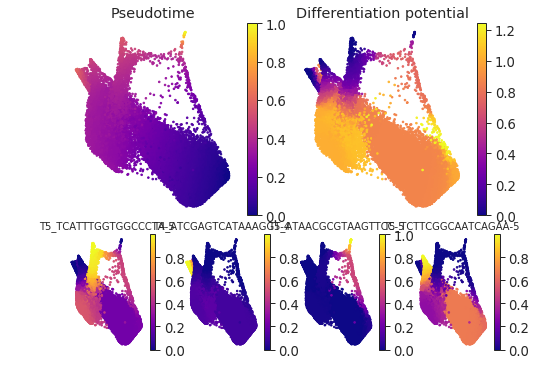

In [78]:
palantir.plot.plot_palantir_results(pr_res, layout)

tSNE layout. Palantir constructs the tSNE map in the embedded space since these maps better represent the differentiation trajectories.

In [149]:
tsne27 = palantir.utils.run_tsne(ms_data, random_state=27)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


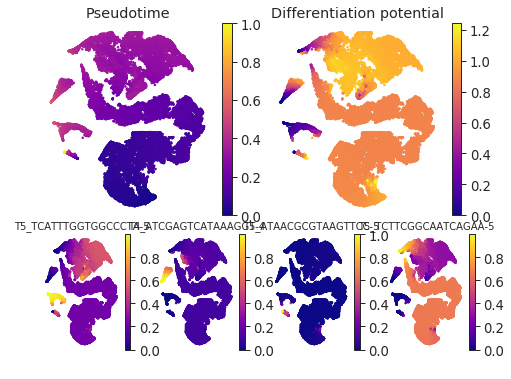

In [148]:
palantir.plot.plot_palantir_results(pr_res, tsne27)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


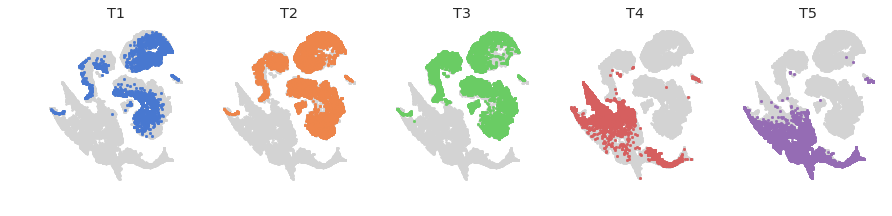

In [152]:
harmony.plot.plot_timepoints(tsne27, tp)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


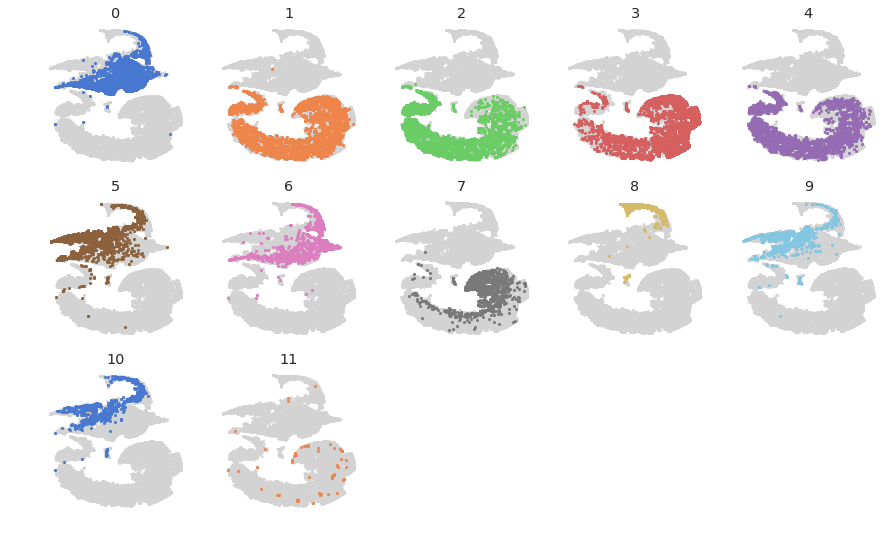

In [146]:
harmony.plot.plot_timepoints(tsne30, metadata['res.0.5'])

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


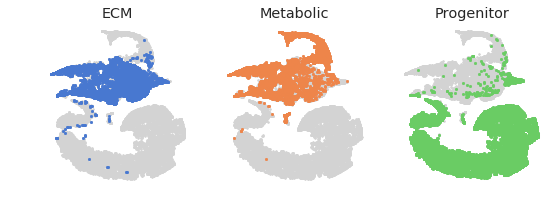

In [143]:
harmony.plot.plot_timepoints(tsne30, metadata['branch'])

Visualizing gene expression

In [ ]:
imp_df = palantir.utils.run_magic_imputation(data_df, dm_res)

Branch marker genes from Monocle analysis. First row are U branch markers, second row L branch markers. 

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


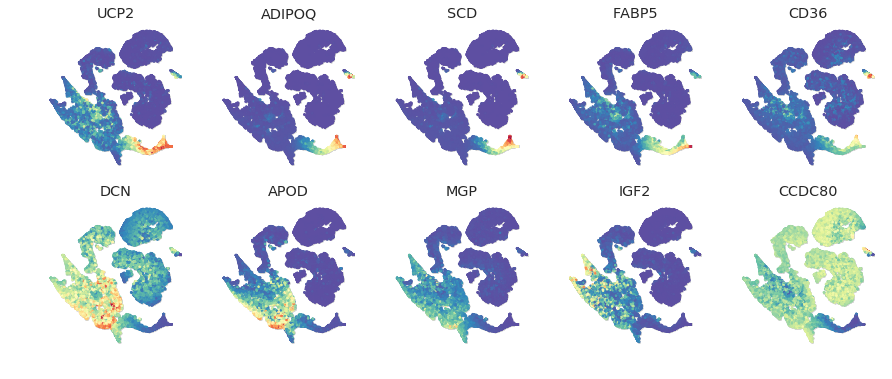

In [153]:
palantir.plot.plot_gene_expression(imp_df, tsne27, ['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36', 'DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'])

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


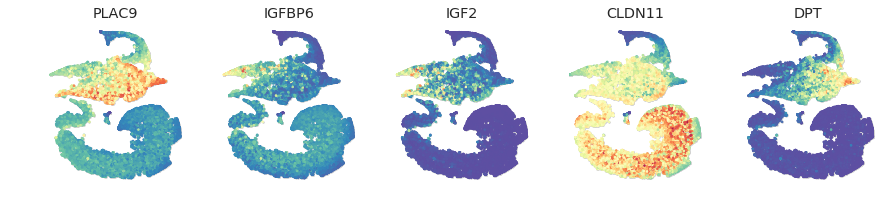

In [147]:
palantir.plot.plot_gene_expression(imp_df, tsne30, ['PLAC9', 'IGFBP6', 'IGF2', 'CLDN11', 'DPT'])


/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


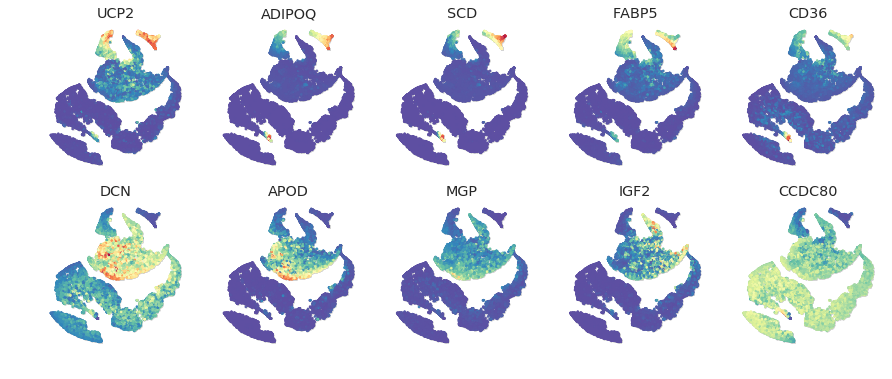

In [103]:
palantir.plot.plot_gene_expression(imp_df, tsne, ['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36', 'DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'])

<b>Layout log transformed data</b>

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


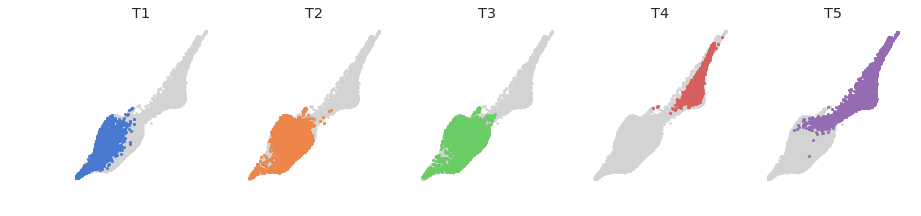

In [18]:
harmony.plot.plot_timepoints(layout_log, tp)

Monocle branches

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


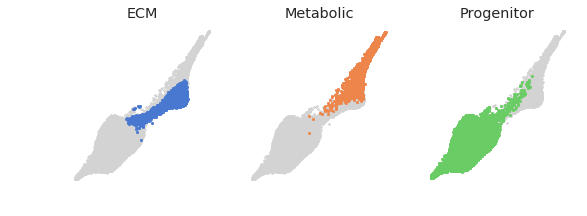

In [22]:
harmony.plot.plot_timepoints(layout_log, metadata['branch'])

<b>Palantir trajectory detection log transformed data</b>

In [23]:
dm_res_log = palantir.utils.run_diffusion_maps(aug_aff_log)
ms_data_log = palantir.utils.determine_multiscale_space(dm_res_log)
ms_data_log.index = data_df_log.index

In [24]:
#Start cell was chosen on Monocle pseudotime == 0.
start_cell = 'T1_TCTGGAAAGTGCGATG-1'
pr_res_log = palantir.core.run_palantir(ms_data_log, start_cell, use_early_cell_as_start=False)

Sampling and flocking waypoints...
Time for determining waypoints: 0.30883690118789675 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 1.2250425378481546 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir results. The second row shows the identified branches.

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


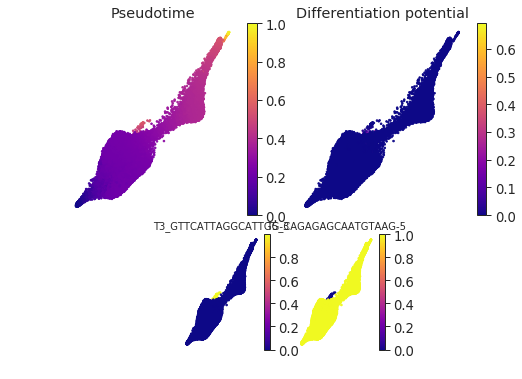

In [25]:
palantir.plot.plot_palantir_results(pr_res_log, layout_log)

tSNE layout. Palantir constructs the tSNE map in the embedded space since these maps better represent the differentiation trajectories.

In [9]:
tsne_log22 = palantir.utils.run_tsne(ms_data_log, random_state=22)

NameError: name 'palantir' is not defined

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


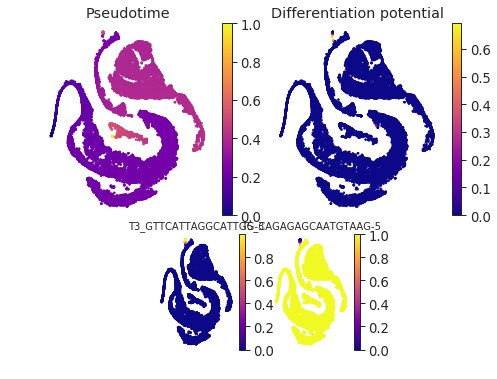

In [27]:
palantir.plot.plot_palantir_results(pr_res_log, tsne_log)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


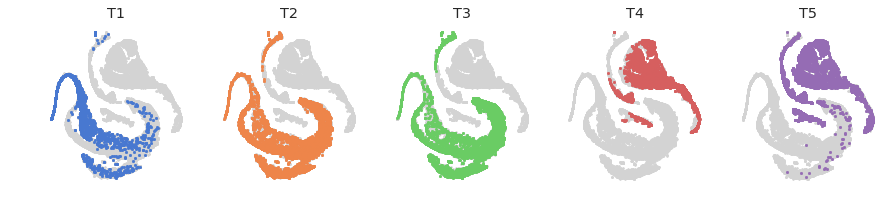

In [28]:
harmony.plot.plot_timepoints(tsne_log, tp)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


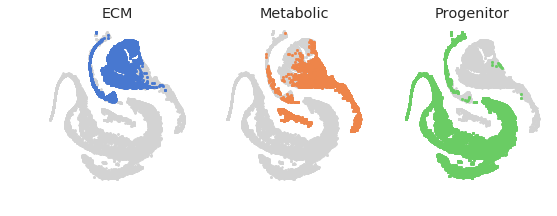

In [29]:
harmony.plot.plot_timepoints(tsne_log, metadata['branch'])

Visualizing gene expression

In [30]:
imp_df_log = palantir.utils.run_magic_imputation(data_df_log, dm_res_log)

Branch marker genes from Monocle analysis. First row are U branch markers, second row L branch markers. 

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


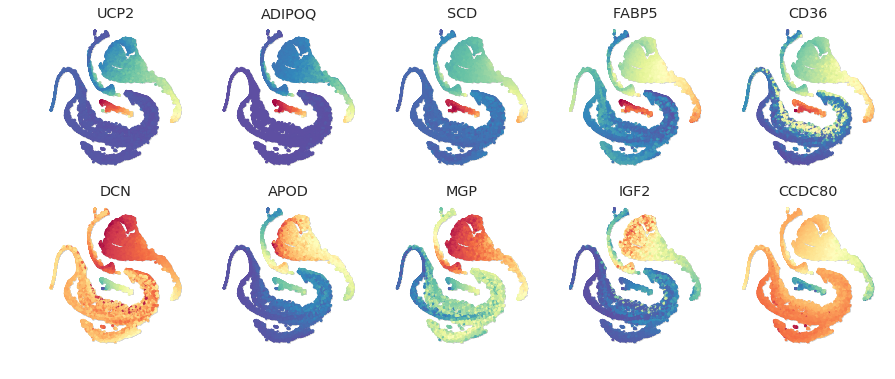

In [31]:
palantir.plot.plot_gene_expression(imp_df_log, tsne_log, ['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36', 'DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'])

<h3>Gene expression trends</h3>